# Non-radial Orbit Correction


In this notebook we will explore the use of an orbit loop up table to correct the implied distance and velocity by relaxing the assumption of radial orbits a bit. We will use the implied distance and radial velocity to search in the precomputed orbits parameter space for the best matching orbit. This orbit will have a velocity vector that will not perfectly align with the galactocentric position vector, meaning that the cross product:

$$ \vec{R} \times \vec{V} = \vec{\Omega} \neq 0 $$

Where $\Omega$ is some non-zero vector that can be computed using the snapshot of the orbit that more closely matches the source. Then:

$$
\bigl(\vec{V}_0 + V_r \,\hat{n} + D \,\vec{\mu}\bigr) \times
\bigl(\vec{R}_0 + D \,\hat{n}\bigr) = \vec{\Omega}.
$$

Taking the dot product with $ \vec{\mu} $ to find the deviation in the velocity, we get:

$$
\vec{\mu} \cdot \Bigl(
\vec{V}_0 \times \vec{R}_0
+ D \, (\vec{V}_0 \times \hat{n})
- V_r \, (\vec{R}_0 \times \hat{n})
+ D \, (\vec{\mu} \times \vec{R}_0)
+ D^2 \, (\vec{\mu} \times \hat{n})
\Bigr)
= \vec{\mu} \cdot \vec{\Omega}.
$$

Which simplifies to:

$$
\vec{\mu} \cdot (\vec{V}_0 \times \vec{R}_0)
+ D \,\vec{\mu} \cdot (\vec{V}_0 \times \hat{n})
- V_r \,\vec{\mu} \cdot (\vec{R}_0 \times \hat{n})
= \vec{\mu} \cdot \vec{\Omega}.
$$

Solving for $ V_r $:

$$
V_r
= \frac{ \vec{\mu} \cdot (\vec{V}_0 \times \vec{R}_0)
+ D\,\vec{\mu} \cdot (\vec{V}_0 \times \hat{n})
- \vec{\mu} \cdot \vec{\Omega}
}{ \vec{\mu} \cdot (\vec{R}_0 \times \hat{n}) }.
$$

Therefore, if we call the purely radial solution $ \tilde{V}_r $, we get:

$$
V_r
= \tilde{V}_r
- \frac{\vec{\mu} \cdot \vec{\Omega}}{\vec{\mu} \cdot (\vec{R}_0 \times \hat{n})}.
$$

Similarly, taking the dot product with $ \hat{n} $ instead of $ \vec{\mu} $ to find the implied distance:

$$
\hat{n} \cdot \Bigl(
\vec{V}_0 \times \vec{R}_0
+ D \, (\vec{V}_0 \times \hat{n})
- V_r \, (\vec{R}_0 \times \hat{n})
+ D \, (\vec{\mu} \times \vec{R}_0)
+ D^2 \, (\vec{\mu} \times \hat{n})
\Bigr)
= \hat{n} \cdot \vec{\Omega}.
$$

Which simplifies to:

$$
(\hat{n} \times \vec{V}_0) \cdot \vec{R}_0
+ D \, \bigl((\hat{n} \times \vec{\mu}) \cdot \vec{R}_0\bigr)
= \hat{n} \cdot \vec{\Omega}.
$$

Solving for $ D $:

$$
D
= \frac{\hat{n} \cdot \vec{\Omega}
+ \hat{n} \cdot (\vec{R}_0 \times \vec{V}_0)}
{ \vec{R}_0 \cdot \bigl(\hat{n} \times \vec{\mu}\bigr)}.
$$

Again, calling the radial solution $ \tilde{D}_I $, we get:

$$
D
= \tilde{D}_I
+ \frac{\hat{n} \cdot \vec{\Omega}}
{ \vec{R}_0 \cdot \bigl(\hat{n} \times \vec{\mu}\bigr)}.
$$

Therefore, the correction to be applied if the trajectory is not strictly radial (given that $ \vec{\Omega} $ is known --- for example, from a lookup table of orbits that reach the current position with a total velocity similar to the source of interest) is as follows. One computes $ \vec{\Omega} $ for the realistic velocity vector, and then applies:

$$
D
= \tilde{D}_I
+ \frac{\hat{n} \cdot \vec{\Omega}}{\vec{R}_0 \cdot (\hat{n} \times \vec{\mu})},
\quad
V_r
= \tilde{V}_r
- \frac{\vec{\mu} \cdot \vec{\Omega}}{\vec{\mu} \cdot (\vec{R}_0 \times \hat{n})}.
$$

Note that if the deviation from a radial orbit is small (1st order perturbation) and given by a small angle $ \delta \alpha $, we will have:

$$
|\vec{\Omega}| = |\vec{R}||\vec{V}|\sin(\delta \alpha) \approx |\vec{R}||\vec{V}| \delta \alpha
$$


## Constructing orbital grid

We will precompute the orbit and then implement some search method to identify the orbit that crosses through the source and more closely aligns with the velocity. 

To reduce the parameter space we will use a potential that does not include a bar, and is therefore axisymmetric. This means that we only need to consider a single angle on a single cuadrant to include all the possible configurations. 

We know that the deviation from no radial orbits will be significant for ejection velocities smaller than about 1500km/s, while also it is not very interesting to look at ejection velocities below the Milky Way bulge escape velocity which is of about 800 km/s. 

In [51]:
# imports
import agama
import numpy as np
from astropy.coordinates import SkyCoord, Galactocentric
from astropy import units as u
from tqdm import tqdm
import os
import sys
import pandas as pd
from astropy.table import Table
from matplotlib import pyplot as plt

# set current directory to /app/data so we can work with relative paths
os.chdir('/app/data/')

# Add the path to the 'scripts' folder directly
sys.path.append('/app/data/')

from scripts import orbit_integration_agama as oia

#import agama
agama.setUnits(mass=1, length=1, velocity=1)


## Single orbit testing

I will start with a single orbit initialized at 3pc from Sag A*, following the procedure done to simulate hypervelocity stars with speedystar (Evans et al. 2022 ). The orbit will be integrated using (Kenyon et al. 2008) axisymmetric potential, which was also used to integrate HVS candidate orbits in Brown et al. 2015

In [52]:
# toy model, single orbit initialized at 3pc from the center (Sag A*)

potential = agama.Potential(file='Agama/brown2015.pot')  # I will use the same potential as Brown et al. 2015


In [54]:
r_i = 3  # initial radius in pc
v_ej = 300  # km/s
theta = np.radians(45)  # angle in degrees from the Z-axis (galactic north pole) perpendicular to the plane of the galaxy
phi = np.radians(0)  # angle in degrees from the X-axis to the projection of the orbit on the galactic plane  

# Convert spherical coordinates to Cartesian coordinates
x = r_i * np.sin(theta) * np.cos(phi)
y = r_i * np.sin(theta) * np.sin(phi)
z = r_i * np.cos(theta)

# Convert velocity components to Cartesian
vx = v_ej * np.sin(theta) * np.cos(phi)
vy = v_ej * np.sin(theta) * np.sin(phi)
vz = v_ej * np.cos(theta)

# Define the initial state
initial_state = np.array([x, y, z, vx, vy, vz] ) # Position in pc and velocity in km/s

# Time settings for orbit integration
t_max = (300 * u.kpc / (v_ej * u.km / u.s)).to(u.Gyr).value  # Convert to Gyr
t_step = 1e-3  # Integration step in Gyr

# Integrate orbit
orbit = agama.orbit(potential=potential, ic=initial_state, time=t_max, dtype = object, trajsize=0)

# Extract trajectory and velocities
trajectory = orbit(orbit)[:, :3]
velocities = orbit(orbit)[:, 3:]

In [66]:
orbit(orbit).shape

(377, 6)

In [63]:
 x, y, z, vx, vy, vz = orbit(orbit)[0], orbit(orbit)[1], orbit(orbit)[2], orbit(orbit)[3], orbit(orbit)[4], orbit(orbit)[5]

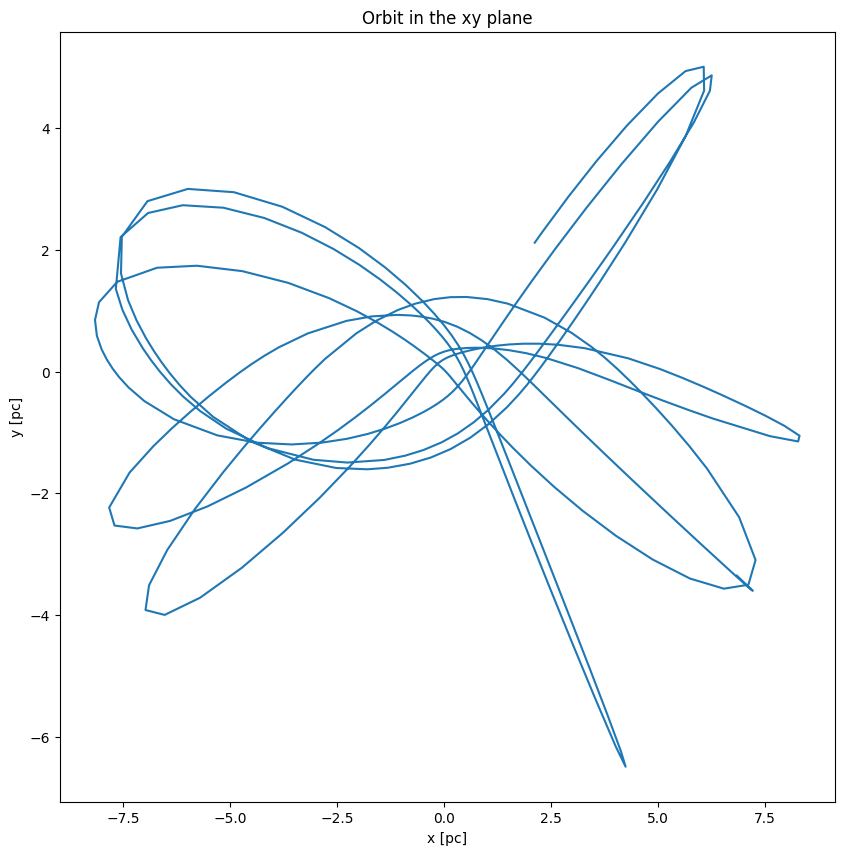

In [6]:
# orbit in the xz plane
plt.figure(figsize=(10, 10))
plt.plot(trajectory[:, 0], trajectory[:, 2])
plt.xlabel('x [pc]')
plt.ylabel('y [pc]')
plt.title('Orbit in the xy plane')
plt.show()

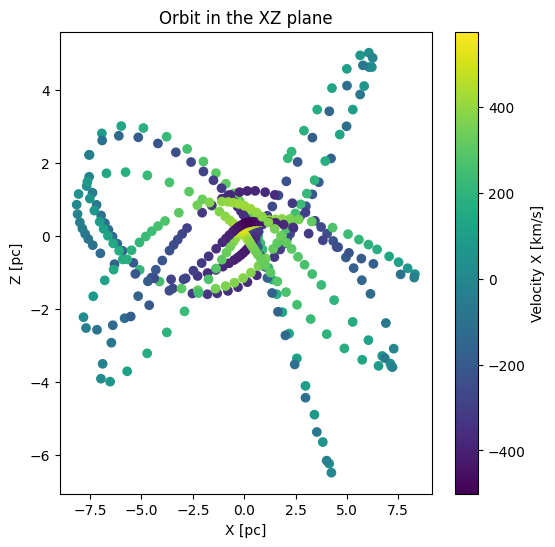

In [7]:
import matplotlib.pyplot as plt

# Normalize the velocity for colormap usage
velocity_x = velocities[:, 0]  # x-component of the velocity
norm = plt.Normalize(vmin=velocity_x.min(), vmax=velocity_x.max())

# Plot the orbit in the XZ plane
plt.figure(figsize=(6, 6))
scatter = plt.scatter(trajectory[:, 0], trajectory[:, 2], c=velocity_x, cmap='viridis', norm=norm)
plt.xlabel('X [pc]')
plt.ylabel('Z [pc]')
plt.title('Orbit in the XZ plane')

# Add a colorbar to indicate velocity scale
cbar = plt.colorbar(scatter)
cbar.set_label('Velocity X [km/s]')

plt.show()


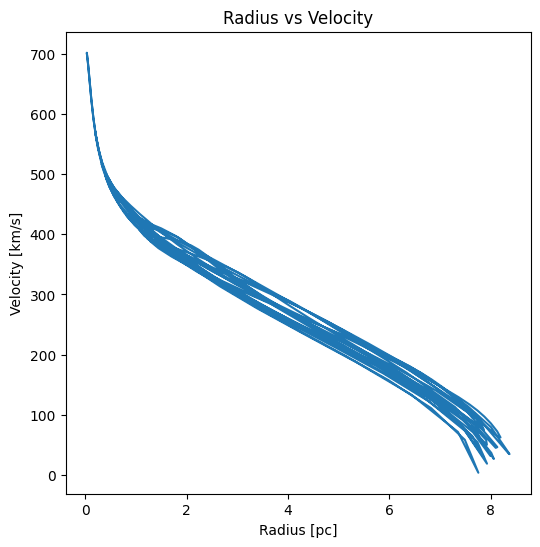

In [8]:
# plot radius vs velocity
r = np.sqrt(np.sum(trajectory**2, axis=1))
v = np.sqrt(np.sum(velocities**2, axis=1))

plt.figure(figsize=(6, 6))
plt.plot(r, v)
plt.xlabel('Radius [pc]')
plt.ylabel('Velocity [km/s]')
plt.title('Radius vs Velocity')
plt.show()

It is working, now I need a way to get only get the orbit before it turns back

In [35]:

def compute_orbit_to_apocenter(r_i, v_ej, theta_rad, phi_rad, potential_file='Agama/brown2015.pot', t_step=1e-3):
    """
    Compute the orbit trajectory and velocities up to the apocenter.

    Parameters:
        r_i (float): Initial radius in pc.
        v_ej (float): Ejection velocity in km/s.
        theta (float): Angle from the Z-axis in radians.
        phi (float): Angle from the X-axis to the projection in the galactic plane in radians.
        potential_file (str): Path to the potential file for the integration.
        t_step (float): Integration step in Gyr.

    Returns:
        tuple: Arrays of positions (x, y, z) and velocities (vx, vy, vz) up to the apocenter.
    """
    # Load the potential
    potential = agama.Potential(file=potential_file)
    
    # Convert spherical to Cartesian coordinates
    x = r_i * np.sin(theta_rad) * np.cos(phi_rad)
    y = r_i * np.sin(theta_rad) * np.sin(phi_rad)
    z = r_i * np.cos(theta_rad)
    vx = v_ej * np.sin(theta_rad) * np.cos(phi_rad)
    vy = v_ej * np.sin(theta_rad) * np.sin(phi_rad)
    vz = v_ej * np.cos(theta_rad)
    
    # Define the initial state
    initial_state = [x, y, z, vx, vy, vz]

    print(initial_state)
    
    # Integration settings
    t_max = (300 * u.kpc / (v_ej * u.km / u.s)).to(u.Gyr).value  # Convert max time to Gyr
    times = np.arange(0, t_max, t_step)
    
    # Integrate orbit
    orbit = agama.orbit(potential=potential, ic=initial_state, time=t_max, dtype = object)#, trajsize=int(t_max/t_step))

    # Extract trajectory and velocities
    positions = orbit(orbit)[:, :3]
    velocities = orbit(orbit)[:, 3:]

    # Find the apocenter
    radial_distances = np.linalg.norm(positions, axis=1)  # Compute radial distances
    apocenter_index = np.argmax(radial_distances)  # Find the index of the apocenter
    
    # Slice the results up to the apocenter
    positions_to_apocenter = positions[:apocenter_index + 1]
    velocities_to_apocenter = velocities[:apocenter_index + 1]
    
    return positions_to_apocenter, velocities_to_apocenter

def compute_orbit_to_first_apocenter(r_i, v_ej, theta_rad, phi_rad, potential_file='Agama/brown2015.pot', n_steps= None):
    """
    Compute the orbit trajectory and velocities up to the first apocenter.

    Parameters:
        r_i (float): Initial radius in pc.
        v_ej (float): Ejection velocity in km/s.
        theta_rad (float): Angle from the Z-axis in radians.
        phi_rad (float): Angle from the X-axis to the projection in the galactic plane in radians.
        potential_file (str): Path to the potential file for the integration.
        t_step (float): Integration step in Gyr.

    Returns:
        tuple: Arrays of positions (x, y, z) and velocities (vx, vy, vz) up to the first apocenter.
    """
    # Load the potential
    potential = agama.Potential(file=potential_file)
    
    # Convert spherical to Cartesian coordinates
    x = r_i * np.sin(theta_rad) * np.cos(phi_rad)
    y = r_i * np.sin(theta_rad) * np.sin(phi_rad)
    z = r_i * np.cos(theta_rad)
    vx = v_ej * np.sin(theta_rad) * np.cos(phi_rad)
    vy = v_ej * np.sin(theta_rad) * np.sin(phi_rad)
    vz = v_ej * np.cos(theta_rad)
    
    # Define the initial state
    initial_state = np.array([x, y, z, vx, vy, vz])
    #print(initial_state)
    # check that inital state is an array of Nx6 of float values
    #assert isinstance(initial_state, np.ndarray), 'Initial state must be a numpy array'
    assert initial_state.shape == (6,), 'Initial state must have shape (6,)'
    if initial_state.dtype != np.float64:
        initial_state = initial_state.ravel()
    assert initial_state.dtype == np.float64, 'Initial state must be of type float64'
    
    # Integration settings
    t_max = (300 * u.kpc / (v_ej * u.km / u.s)).to(u.Gyr).value  
    # Max time is defined as the time it takes to
    #  reach the MW virial radius, in practice most objects will not get here but we can guarantee that
    #  all the orbit of interest will exist in this time. 
    
    # Integrate orbit
    # If n_steps is not None, set the trajectory size to n_steps
    if n_steps is not None:
        orbit = agama.orbit(potential=potential, ic=initial_state, time=t_max, dtype = object, trajsize=n_steps)
    # If not, let Agama decide the trajectory size automatically using adaptive step size
    else:
        orbit = agama.orbit(potential=potential, ic=initial_state, time=t_max, dtype = object)#, trajsize=int(t_max/t_step))

    # Extract trajectory and velocities
    positions = orbit(orbit)[:, :3]
    velocities = orbit(orbit)[:, 3:]

    # Compute radial distances
    radial_distances = np.linalg.norm(positions, axis=1)

    # Find the first apocenter
    for i in range(1, len(radial_distances) - 1):
        if radial_distances[i] > radial_distances[i - 1] and radial_distances[i] > radial_distances[i + 1]:
            apocenter_index = i
            break
    else:
        apocenter_index = len(radial_distances) - 1  # Default to the last point if no apocenter is found

    # Slice the results up to the first apocenter
    positions_to_first_apocenter = positions[:apocenter_index + 1]
    velocities_to_first_apocenter = velocities[:apocenter_index + 1]
    
    return positions_to_first_apocenter, velocities_to_first_apocenter, orbit


# Compute the orbit up to the first apocenter but using the Rperiapo(E, L) agama function


def compute_orbit_to_first_apocenter_2(r_i, v_ej, theta_rad, phi_rad, potential_file='Agama/brown2015.pot', n_steps= None):
    """
    Compute the orbit trajectory and velocities up to the first apocenter.

    Parameters:
        r_i (float): Initial radius in pc.
        v_ej (float): Ejection velocity in km/s.
        theta_rad (float): Angle from the Z-axis in radians.
        phi_rad (float): Angle from the X-axis to the projection in the galactic plane in radians.
        potential_file (str): Path to the potential file for the integration.
        t_step (float): Integration step in Gyr.

    Returns:
        tuple: Arrays of positions (x, y, z) and velocities (vx, vy, vz) up to the first apocenter.
    """
    # Load the potential
    potential = agama.Potential(file=potential_file)
    
    # Convert spherical to Cartesian coordinates
    x = r_i * np.sin(theta_rad) * np.cos(phi_rad)
    y = r_i * np.sin(theta_rad) * np.sin(phi_rad)
    z = r_i * np.cos(theta_rad)
    vx = v_ej * np.sin(theta_rad) * np.cos(phi_rad)
    vy = v_ej * np.sin(theta_rad) * np.sin(phi_rad)
    vz = v_ej * np.cos(theta_rad)
    
    # Define the initial state
    initial_state = [x, y, z, vx, vy, vz]
    
    # Compute energy and angular momentum
    E_i = potential.potential(x, y, z) + 0.5 * (vx**2 + vy**2 + vz**2)
    # Angular momentum will always be 0 for radial orbits
    L_i = 0

    print('Initial energy:', E_i)
    print('Initial angular momentum:', L_i)

    # Compute the apocenter using the Rperiapo function
    apocenter_raddi = potential.Rperiapo(E_i, L_i)

    print('Apocenter radius:', apocenter_raddi)
    print('Integration time to apocenter:', apocenter_raddi*u.kpc /( v_ej*u.km/u.s).to(u.kpc/u.Gyr), 'Gyr')

    # Integration settings
    t_max = (apocenter_raddi[1]*u.kpc /( v_ej*u.km/u.s).to(u.pc/u.Gyr)).value
    # Max time is defined as the time it takes to
    #  reach the MW virial radius, in practice most objects will not get here but we can guarantee that
    #  all the orbit of interest will exist in this time. 
    
    # Integrate orbit
    # If n_steps is not None, set the trajectory size to n_steps
    if n_steps is not None:
        orbit = agama.orbit(potential=potential, ic=initial_state, time=t_max, dtype = object, trajsize=n_steps)
    # If not, let Agama decide the trajectory size automatically using adaptive step size
    else:
        orbit = agama.orbit(potential=potential, ic=initial_state, time=t_max, dtype = object)#, trajsize=int(t_max/t_step))

    # Extract trajectory and velocities
    positions = orbit(orbit)[:, :3]
    velocities = orbit(orbit)[:, 3:]

    # Compute radial distances
    radial_distances = np.linalg.norm(positions, axis=1)

    # Find the first apocenter
    for i in range(1, len(radial_distances) - 1):
        if radial_distances[i] > radial_distances[i - 1] and radial_distances[i] > radial_distances[i + 1]:
            apocenter_index = i
            break
    else:
        apocenter_index = len(radial_distances) - 1  # Default to the last point if no apocenter is found

    # Slice the results up to the first apocenter
    positions_to_first_apocenter = positions[:apocenter_index + 1]
    velocities_to_first_apocenter = velocities[:apocenter_index + 1]
    
    return positions_to_first_apocenter, velocities_to_first_apocenter, orbit

In [36]:
r_i = 3  # initial radius in pc
v_ej = 300  # km/s
theta = np.radians(45)  # angle in degrees from the Z-axis (galactic north pole) perpendicular to the plane of the galaxy
phi = np.radians(0)  # angle in degrees from the X-axis to the projection of the orbit on the galactic plane  

postions_to_apocenter, velocities_to_apocenter, orbit_interpolator = compute_orbit_to_first_apocenter(r_i, v_ej, theta,
                                                                                                       phi, n_steps=1000)

In [37]:
# r_i = 3  # initial radius in pc
# v_ej = 300  # km/s
# theta = np.radians(45)  # angle in degrees from the Z-axis (galactic north pole) perpendicular to the plane of the galaxy
# phi = np.radians(0)  # angle in degrees from the X-axis to the projection of the orbit on the galactic plane  

# postions_to_apocenter, velocities_to_apocenter, orbit_interpolator = compute_orbit_to_first_apocenter_2(r_i, v_ej,
#                                                                                                          theta, phi,
#                                                                                                            n_steps=1000)

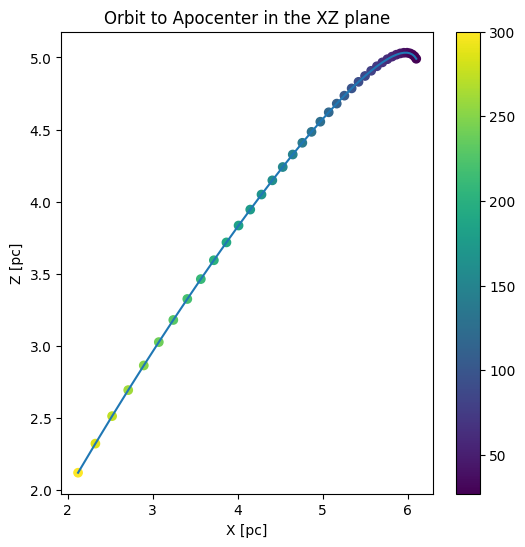

In [38]:
velocity_r = np.sqrt(np.sum(velocities_to_apocenter**2, axis=1))
plt.figure(figsize=(6, 6))
plt.plot(postions_to_apocenter[:, 0], postions_to_apocenter[:, 2])
plt.scatter(postions_to_apocenter[:, 0], postions_to_apocenter[:, 2], c=velocity_r, label='Start')
plt.colorbar()
plt.xlabel('X [pc]')
plt.ylabel('Z [pc]')
plt.title('Orbit to Apocenter in the XZ plane')
plt.show()

In [13]:
# Now for any given final condition we need an orbit that:
# 1. Intersects the final condition before the apocenter 
# 2. Has a total velocity that is similar to the final condition

import numpy as np
from scipy.optimize import minimize


def get_initial_velocity(r_f, theta_f, v_f, phi_rad=0, potential_file='Agama/brown2015.pot'):
    """
    Use conservation of energy to find the initial velocity
    """
    # Load the potential
    potential = agama.Potential(file=potential_file)

    # Convert the desired final condition to Cartesian
    x_f = r_f * np.sin(theta_f) * np.cos(phi_rad)
    y_f = r_f * np.sin(theta_f) * np.sin(phi_rad)
    z_f = r_f * np.cos(theta_f)

    vx_f = v_f * np.sin(theta_f) * np.cos(phi_rad)
    vy_f = v_f * np.sin(theta_f) * np.sin(phi_rad)
    vz_f = v_f * np.cos(theta_f)

    # Compute the energy at the final position
    Energy = potential.potential(x, y, z) + 0.5 * (vx**2 + vy**2 + vz**2)

    # Compute the initial velocity using conservation of energy
    v_i = np.sqrt(2 * (Energy - potential.potential(0, 0, 3)))

    return v_i


In [14]:
import numpy as np
from scipy.optimize import minimize



def objective_theta(theta_i, v_i, r_f, theta_f, v_f, phi_rad=0, potential_file='Agama/brown2015.pot'):
    """
    Objective function that computes the minimum mismatch between the orbit
    and the desired final conditions (r_f, theta_f, v_f) at any point.

    Now we only optimize over theta_i, while v_i is fixed (from energy).
    """
    r_i = 3.0  # pc (fixed)

    # Integrate the orbit from the initial conditions (r_i, v_i, theta_i)
    positions, velocities, _ = compute_orbit_to_first_apocenter( r_i=r_i, v_ej=v_i,
                                                                theta_rad=theta_i,
                                                                phi_rad=phi_rad,
                                                                potential_file=potential_file,
                                                                n_steps=1000
    )

    # Convert the desired final condition to Cartesian
    x_f = r_f * np.sin(theta_f) * np.cos(phi_rad)
    y_f = r_f * np.sin(theta_f) * np.sin(phi_rad)
    z_f = r_f * np.cos(theta_f)

    vx_f = v_f * np.sin(theta_f) * np.cos(phi_rad)
    vy_f = v_f * np.sin(theta_f) * np.sin(phi_rad)
    vz_f = v_f * np.cos(theta_f)

    target_pos = np.array([x_f, y_f, z_f])
    target_vel = np.array([vx_f, vy_f, vz_f])

    # For each point in the orbit, compute mismatch in position + velocity
    min_mismatch = np.inf
    for pos, vel in zip(positions, velocities):
        dpos = np.linalg.norm(pos - target_pos)
        dvel = np.linalg.norm(vel - target_vel)
        mismatch = dpos + dvel
        if mismatch < min_mismatch:
            min_mismatch = mismatch

    return min_mismatch


def find_initial_conditions(r_f, theta_f, v_f, phi_rad=0, potential_file='Agama/brown2015.pot'):
    """
    1) Compute the initial velocity v_i using conservation of energy.
    2) Optimize only over theta_i in [0, pi] to minimize the mismatch.
    3) Return (v_i, theta_i_opt).
    """
    # 1) Compute initial velocity from energy conservation
    v_i = get_initial_velocity(r_f, theta_f, v_f, phi_rad, potential_file)

    # 2) Optimize only over theta_i
    #    Use the final angle as an initial guess or you can guess 0, etc.
    theta_guess = theta_f  
    bounds = [(0.0, np.pi/2)]

    def objective_wrapper(theta_trial):
        return objective_theta(theta_trial[0], v_i, r_f, theta_f, v_f,
                               phi_rad=phi_rad, potential_file=potential_file)

    result = minimize(objective_wrapper, x0=[theta_guess], bounds=bounds)

    if not result.success:
        raise RuntimeError("Optimization for theta_i did not converge.")

    theta_i_opt = result.x[0]

    # 3) Return the (already known) v_i and the optimized angle
    return v_i, theta_i_opt



In [15]:

r_f_example = 10.0         # pc
theta_f_example = np.pi/4  # rad
v_f_example = 200.0        # km/s

v_i_found, theta_i_found = find_initial_conditions( # compute_orbit_to_first_apocenter(r_i, v_ej, theta_rad, phi_rad,
    r_f_example,
    theta_f_example,
    v_f_example,
    phi_rad=0,
)

print(f"Optimized initial velocity = {v_i_found:.3f} km/s")
print(f"Optimized initial angle    = {theta_i_found:.3f} rad")


Optimized initial velocity = 287.646 km/s
Optimized initial angle    = 0.719 rad


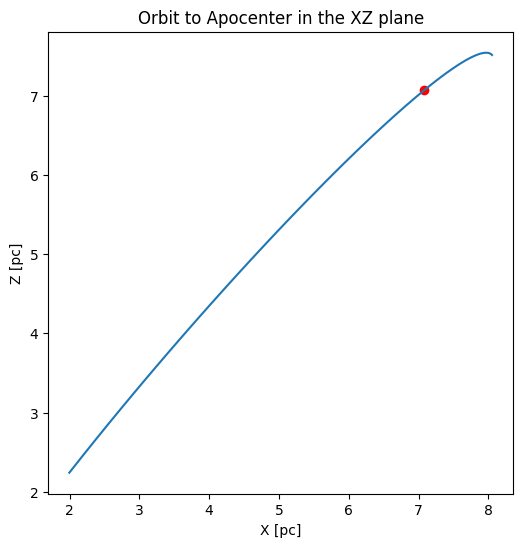

In [16]:
# compute the orbit with the optimized initial conditions
r_i = 3  # initial radius in pc
v_ej = 350#v_i_found  # km/s
theta = theta_i_found + np.radians(0.5)  # angle in degrees from the Z-axis (galactic north pole) perpendicular to the plane of the galaxy
phi = np.radians(0)  # angle in degrees from the X-axis to the projection of the orbit on the galactic plane

postions_to_apocenter, velocities_to_apocenter, orbit_interpolator = compute_orbit_to_first_apocenter(r_i, v_ej, theta, phi, n_steps=1000)

# convert example final conditions to Cartesian
x_f = r_f_example * np.sin(theta_f_example) * np.cos(phi)
y_f = r_f_example * np.sin(theta_f_example) * np.sin(phi)
z_f = r_f_example * np.cos(theta_f_example)


plt.figure(figsize=(6, 6))
plt.plot(postions_to_apocenter[:, 0], postions_to_apocenter[:, 2], label = 'Best fit Orbit')
plt.scatter(x_f, z_f, c='red', label='Source')
plt.xlabel('X [pc]')
plt.ylabel('Z [pc]')
plt.title('Orbit to Apocenter in the XZ plane')
plt.show()

# Finding both $V_ej$ and $\theta$

In [17]:
import numpy as np
from scipy.optimize import minimize

# We assume these two functions are already defined somewhere above:
# 1) get_initial_velocity(r_f, theta_f, v_f, phi_rad, potential_file)
# 2) compute_orbit_to_first_apocenter(r_i, v_ej, theta_rad, phi_rad, potential_file, n_steps=None)

def objective(params, r_f, theta_f, v_f, phi_rad=0, potential_file='Agama/brown2015.pot'):
    """
    Objective function that computes the minimum mismatch between the orbit
    and the desired final conditions (r_f, theta_f, v_f) at any point.
    
    Parameters
    ----------
    params : array-like
        [v_i, theta_i]
    r_f, theta_f, v_f : float
        Desired final conditions for the orbit.
    phi_rad : float
        Azimuthal angle in the galactic plane (fixed to 0 in your problem).
    potential_file : str
        Path to the Agama potential file.

    Returns
    -------
    mismatch : float
        The minimum mismatch (position + velocity) along the orbit.
    """
    v_i, theta_i = params
    r_i = 3.0  # pc (fixed initial radius)

    # Integrate the orbit from these initial conditions
    positions, velocities, _ = compute_orbit_to_first_apocenter(
        r_i=r_i,
        v_ej=v_i,
        theta_rad=theta_i,
        phi_rad=phi_rad,
        potential_file=potential_file,
        n_steps=1000
    )

    # Convert the desired final condition to Cartesian
    x_f = r_f * np.sin(theta_f) * np.cos(phi_rad)
    y_f = r_f * np.sin(theta_f) * np.sin(phi_rad)
    z_f = r_f * np.cos(theta_f)

    vx_f = v_f * np.sin(theta_f) * np.cos(phi_rad)
    vy_f = v_f * np.sin(theta_f) * np.sin(phi_rad)
    vz_f = v_f * np.cos(theta_f)

    target_pos = np.array([x_f, y_f, z_f])
    target_vel = np.array([vx_f, vy_f, vz_f])

    # Find the minimum phase-space mismatch at any point in the orbit
    min_mismatch = np.inf
    for pos, vel in zip(positions, velocities):
        dpos = np.linalg.norm(pos - target_pos)
        dvel = np.linalg.norm(vel - target_vel)
        mismatch = dpos + dvel
        if mismatch < min_mismatch:
            min_mismatch = mismatch

    return min_mismatch

def find_initial_conditions(r_f, theta_f, v_f, phi_rad=0, potential_file='Agama/brown2015.pot'):
    """
    1) Use get_initial_velocity(...) as a starting guess for v_i.
    2) Optimize over both [v_i, theta_i] to minimize the mismatch with
       the desired final conditions (r_f, theta_f, v_f).

    Parameters
    ----------
    r_f : float
        Desired final radius in pc.
    theta_f : float
        Desired final angle from Z-axis in radians.
    v_f : float
        Desired final velocity magnitude in km/s.
    phi_rad : float, optional
        Azimuthal angle (rad). Default=0.
    potential_file : str, optional
        Path to the Agama potential file.

    Returns
    -------
    (v_i_opt, theta_i_opt) : tuple
        The optimized initial velocity (km/s) and polar angle (rad).
    """
    # 1) Compute a physically motivated guess for v_i using energy conservation
    v_i_guess = get_initial_velocity(r_f, theta_f, v_f, phi_rad, potential_file)

    # Use the final angle as a guess for theta_i
    theta_guess = theta_f
    initial_guess = [v_i_guess, theta_guess]

    # Bounds: 
    #  - v_i >= 0  (no upper bound => None)
    #  - theta_i in [0, pi/2] or [0, pi], depending on your problem domain.
    bounds = [(200, 1500), (0, np.pi/2)]

    # 2) Minimize the objective function over [v_i, theta_i]
    def objective_wrapper(params):
        return objective(params, r_f, theta_f, v_f, phi_rad, potential_file)

    result = minimize(
        objective_wrapper,
        x0=initial_guess,
        bounds=bounds
    )

    if not result.success:
        raise RuntimeError("Optimization for [v_i, theta_i] did not converge.")

    v_i_opt, theta_i_opt = result.x
    return v_i_opt, theta_i_opt


# Example usage (uncomment if you want to run a quick test):
r_f_example = 15.0
theta_f_example = np.pi / 4
v_f_example = 200.0
v_i_final, theta_i_final = find_initial_conditions(
    r_f_example, theta_f_example, v_f_example, phi_rad=0
)
print(f"Optimized initial velocity: {v_i_final:.3f} km/s")
print(f"Optimized initial angle:    {theta_i_final:.3f} rad")


Optimized initial velocity: 284.191 km/s
Optimized initial angle:    0.716 rad


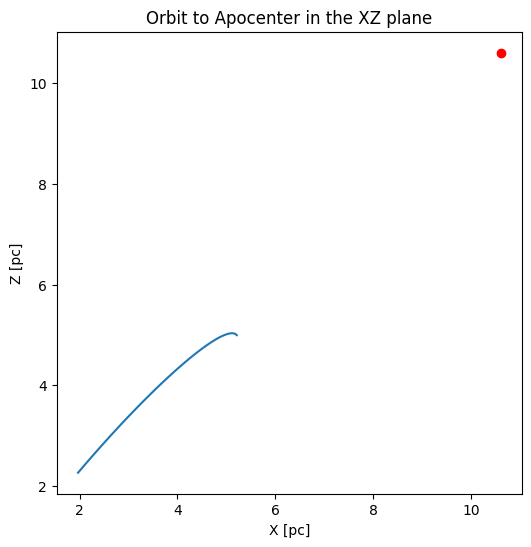

In [18]:
# compute the orbit with the optimized initial conditions
r_i = 3  # initial radius in pc
v_ej = 350#v_i_found  # km/s
theta = theta_i_found + np.radians(0.5)  # angle in degrees from the Z-axis (galactic north pole) perpendicular to the plane of the galaxy
phi = np.radians(0)  # angle in degrees from the X-axis to the projection of the orbit on the galactic plane

postions_to_apocenter, velocities_to_apocenter, orbit_interpolator = compute_orbit_to_first_apocenter(r_i, v_i_final, theta_i_final, 0, n_steps=1000)

# convert example final conditions to Cartesian
x_f = r_f_example * np.sin(theta_f_example) * np.cos(phi)
y_f = r_f_example * np.sin(theta_f_example) * np.sin(phi)
z_f = r_f_example * np.cos(theta_f_example)


plt.figure(figsize=(6, 6))
plt.plot(postions_to_apocenter[:, 0], postions_to_apocenter[:, 2], label = 'Best fit Orbit')
plt.scatter(x_f, z_f, c='red', label='Source')
plt.xlabel('X [pc]')
plt.ylabel('Z [pc]')
plt.title('Orbit to Apocenter in the XZ plane')
plt.show()

# Sergey Version

Using cilindrical coordinates we can express the velocity as a sum of $V_R$, $V_Z$ components, radial and z-component. Given a galactocentric latitud angle of ejection $\phi_{ej}$ the components of the velocity will be given by the orbit as a function of time and initial conditions:

$$ V_R(\phi_{ej}, V_{ej}, t) $$ 
$$ V_z(\phi_{ej}, V_{ej}, t) $$

This is just saying that they are a function of the position of the orbit, which is a function of time and initial conditions. Radius is also a function of time, so both functions can also be expressed as a function of radius. In the same way there is only one ejection angle that given an ejection velocity will give you the same orbit



In [25]:
import gala.potential as gp
import gala.integrate as gi
import gala.dynamics as gd
import astropy.units as auni
import astropy.coordinates as acoo
import numpy as np

pot = gp.MilkyWayPotential2022()
kms = auni.km / auni.s

acoo.galactocentric_frame_defaults.set('latest')


def doit(vej, cosang, t):
    #cosang = np.cos(ang)
    #sinang = np.sin(ang)
    sinang = np.sqrt(1 - cosang**2)
    startpos = np.array([cosang, 0, sinang]) * auni.kpc
    vel = np.array([cosang, 0, sinang]) * vej
    w0 = gd.PhaseSpacePosition(startpos, vel=vel * kms)
    nsteps = 1000
    timestep = t * auni.Myr / nsteps
    orbit = gp.Hamiltonian(pot).integrate_orbit(
        w0,
        dt=timestep,
        n_steps=nsteps,
        Integrator=gi.DOPRI853Integrator,
        # Integrator_kwargs = dict(atol=1e-15,rtol=1e-15)
    )
    R = (orbit.x**2 + orbit.z**2 + orbit.y**2)**.5
    z = orbit.z.to_value(auni.kpc)
    VR = orbit.v_x * R / orbit.x
    Vz = orbit.v_z - orbit.v_x * orbit.z / orbit.x
    return R.to_value(auni.kpc), z, VR.to_value(kms), Vz.to_value(kms), orbit.t.to_value(auni.Myr), orbit.x.to_value(auni.kpc), orbit.y.to_value(auni.kpc), orbit.z.to_value(auni.kpc), orbit.v_x.to_value(kms), orbit.v_y.to_value(kms), orbit.v_z.to_value(kms)


def doall(N=10000, seed=3):
    rng = np.random.default_rng(seed)
    vej = 10**rng.uniform(2.8, 4, size=N)
    cosa = rng.uniform(0, 1, size=N)
    times = 100
    r1, r2, r3, r4 = [], [], [], []
    r5, r6, r7, r8, r9, r10, r11 = [], [], [], [], [], [], []
    for curv, curc in tqdm(zip(vej, cosa), total=N):
        R, z, VR, Vz, t, x, y, z, vx, vy, vz = doit(curv, curc, times)
        r1.append(R)
        r2.append(z)
        r3.append(VR)
        r4.append(Vz)
        r5.append(t)
        r6.append(x)
        r7.append(y)
        r8.append(z)
        r9.append(vx)
        r10.append(vy)
        r11.append(vz)

    return [np.array(_) for _ in [r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11]]


In [20]:
import gala.potential as gp
import gala.integrate as gi
import gala.dynamics as gd
import astropy.units as auni
import astropy.coordinates as acoo
import numpy as np

pot = gp.MilkyWayPotential2022()
kms = auni.km / auni.s

acoo.galactocentric_frame_defaults.set('latest')


def doit(vej, cosang, t):
    #cosang = np.cos(ang)
    #sinang = np.sin(ang)
    sinang = np.sqrt(1 - cosang**2)
    startpos = np.array([cosang, 0, sinang]) * auni.kpc
    vel = np.array([cosang, 0, sinang]) * vej
    w0 = gd.PhaseSpacePosition(startpos, vel=vel * kms)
    nsteps = 1000
    timestep = t * auni.Myr / nsteps
    orbit = gp.Hamiltonian(pot).integrate_orbit(
        w0,
        dt=timestep,
        n_steps=nsteps,
        Integrator=gi.DOPRI853Integrator,
        # Integrator_kwargs = dict(atol=1e-15,rtol=1e-15)
    )
    R = (orbit.x**2 + orbit.z**2 + orbit.y**2)**.5
    z = orbit.z.to_value(auni.kpc)
    VR = orbit.v_x * R / orbit.x
    Vz = orbit.v_z - orbit.v_x * orbit.z / orbit.x
    return R.to_value(auni.kpc), z, VR.to_value(kms), Vz.to_value(kms)


def doall(N=10000, seed=3):
    rng = np.random.default_rng(seed)
    vej = 10**rng.uniform(2.8, 4, size=N)
    cosa = rng.uniform(0, 1, size=N)
    times = 100
    r1, r2, r3, r4 = [], [], [], []
    for curv, curc in zip(vej, cosa):
        R, z, VR, Vz = doit(curv, curc, times)
        r1.append(R)
        r2.append(z)
        r3.append(VR)
        r4.append(Vz)

    return [np.array(_) for _ in [r1, r2, r3, r4]]

R, z, VR, Vz = doall()

In [26]:
R, z, VR, Vz, t,x, y, z, vx, vy, vz   = doall(10000, 3)

100%|██████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:52<00:00, 190.90it/s]


In [27]:
# select radius between 20 and 25 pc
mask = (R > 20) & (R < 25)
R_masked = R[mask]

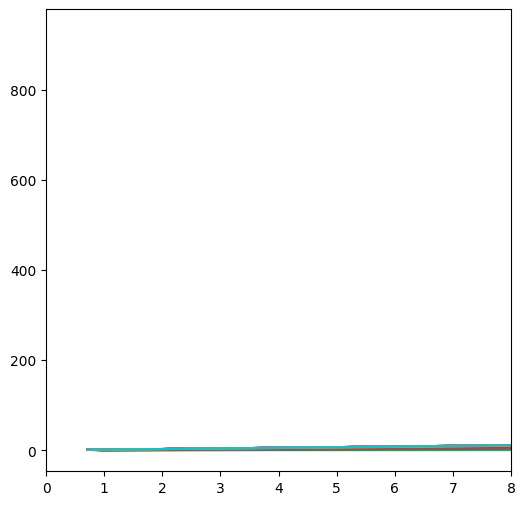

In [29]:
# plot a few of the orbits 

# transform cylindrical to cartesian
#x = R * np.cos(np.arctan2(z, R))

plt.figure(figsize=(6, 6))
for i in range(0, 100):
    plt.plot(x[i], z[i])
#plt.plot(x[0], z[0])
plt.xlim(0, 8)
plt.show()

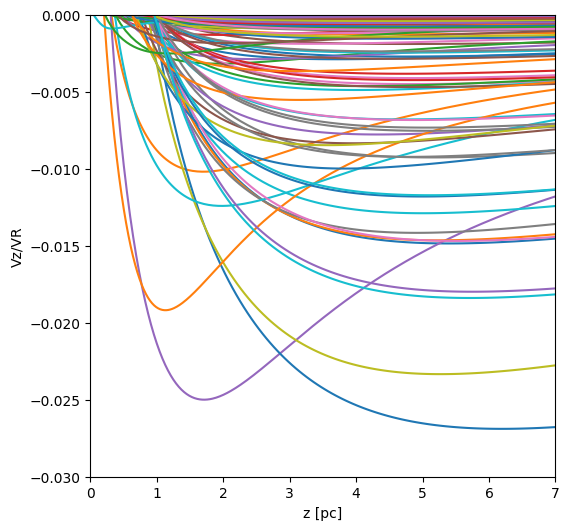

In [34]:
# plot Vz/VR vs z for a range of R
# REPLICATE SERGEY PLOT

plt.figure(figsize=(6, 6))
for i in range(0, 100):
    plt.plot(z[i], Vz[i]/VR[i])
plt.xlabel('z [pc]')
plt.ylabel('Vz/VR')
#plt.yscale('symlog')
plt.xlim(0, 7)
plt.ylim(-0.03,  0)
plt.show()

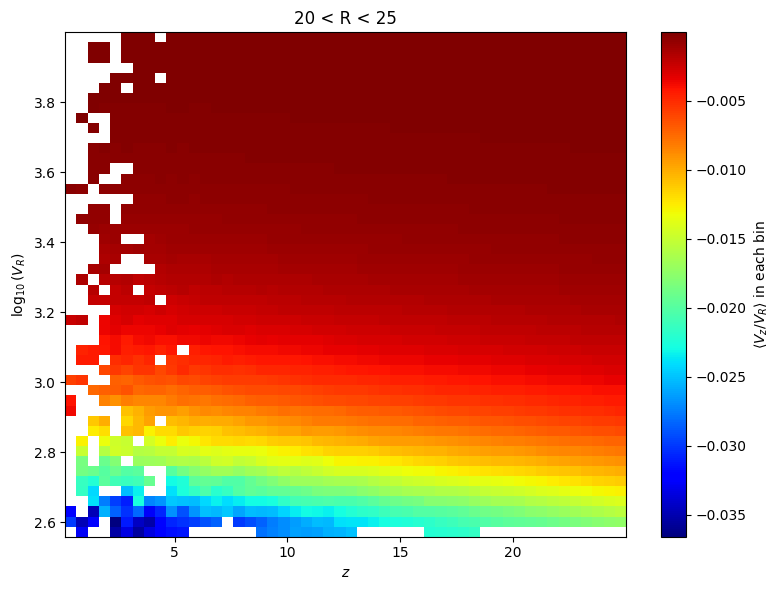

In [140]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d

# Suppose R, z, VR, Vz have shape (10000, 1001)
# Each row = one orbit; each column = points in that orbit.
# Flatten them to treat them as a single set of points.
# (Careful if you really want to separate orbits vs. all together.)
zf = z.flatten()
VRf = VR.flatten()
Vzf = Vz.flatten()
Rf = R.flatten()

# Compute log10(VR) where VR>0. Mask out or filter negative/zero values if needed.
# Here we assume VR is always > 0. Otherwise you'd do something like:
mask = (Rf < 25) & (Rf > 20)
Rf = Rf[mask]
zf = zf[mask]
VRf = VRf[mask]
Vzf = Vzf[mask]
logVRf = np.log10(VRf)

# Compute ratio
ratio = Vzf / VRf

# Choose how many bins you want in each dimension
xbins = 50  # bins in z
ybins = 50  # bins in log10(VR)

# Use binned_statistic_2d to compute the mean ratio in each (z, logVR) bin
# statistic='mean' can also be 'median', 'count', 'sum', etc.
stat, xedges, yedges, binnum = binned_statistic_2d(
    x=zf,
    y=logVRf,
    values=ratio,
    statistic='mean',
    bins=[xbins, ybins]
)

# 'stat' is a 2D array of the same shape as bins: (xbins, ybins)
# We can plot it with pcolormesh (or imshow).
plt.figure(figsize=(8, 6))
# Note that stat is indexed as stat[ix, iy], but pcolormesh expects
# xedges (length xbins+1) along the horizontal axis, yedges (length ybins+1)
# along the vertical axis, so we transpose 'stat' in pcolormesh.
plt.pcolormesh(xedges, yedges, stat.T, cmap='jet', shading='auto')

# Colorbar labeling
cb = plt.colorbar()
cb.set_label(r'$\langle V_z / V_R \rangle$ in each bin')

plt.xlabel(r'$z$')
plt.ylabel(r'$\log_{10}(V_R)$')
plt.title('20 < R < 25')
plt.tight_layout()
plt.show()


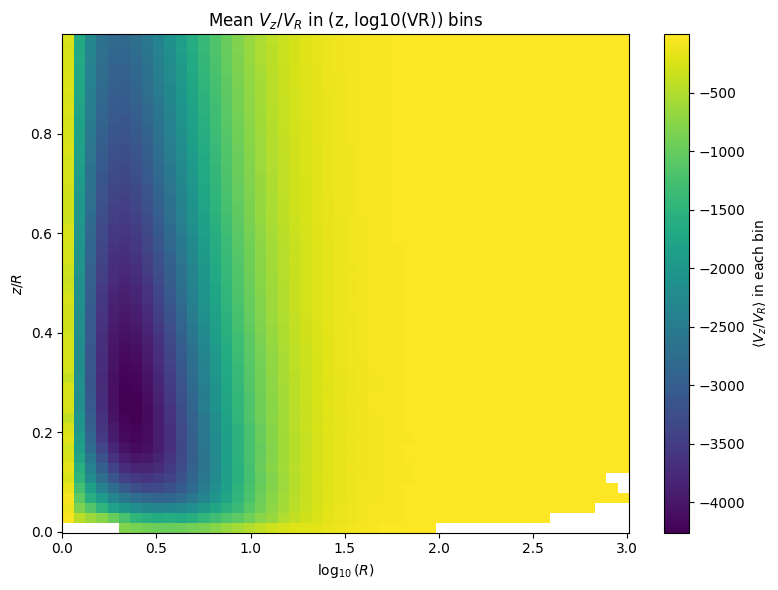

In [157]:

# Choose how many bins you want in each dimension
xbins = 50  # bins in z
ybins = 50  # bins in log10(VR)

zf = z.flatten()
VRf = VR.flatten()
Vzf = Vz.flatten()
Rf = R.flatten()

ratio = Vzf/Rf*VRf
# Use binned_statistic_2d to compute the mean ratio in each (z, logVR) bin
# statistic='mean' can also be 'median', 'count', 'sum', etc.
stat, xedges, yedges, binnum = binned_statistic_2d(
    y=zf/Rf,
    x=np.log10(Rf),
    values=ratio,
    statistic='mean',
    bins=[xbins, ybins]
)

# 'stat' is a 2D array of the same shape as bins: (xbins, ybins)
# We can plot it with pcolormesh (or imshow).
plt.figure(figsize=(8, 6))
# Note that stat is indexed as stat[ix, iy], but pcolormesh expects
# xedges (length xbins+1) along the horizontal axis, yedges (length ybins+1)
# along the vertical axis, so we transpose 'stat' in pcolormesh.
plt.pcolormesh(xedges, yedges, stat.T, cmap='viridis', shading='auto')#, vmin= - 10000, vmax= 0)

# Colorbar labeling
cb = plt.colorbar()
cb.set_label(r'$\langle V_z / V_R \rangle$ in each bin')

plt.xlabel(r'$\log_{10}(R)$')
plt.ylabel(r'$z/R$')
plt.title('Mean $V_z / V_R$ in (z, log10(VR)) bins')
plt.tight_layout()
#plt.xlim(-2, 2)
plt.show()

In [134]:
logR = np.log10((x**2 + y**2 + z**2)**0.5)

# Computing $\Omega(V_{ej}, \phi_{ej}, t)$

In [102]:
import numpy as np

# Suppose R, z, VR, Vz each have shape (nOrbits, nPoints)
# For example:
# R, z, VR, Vz = doall(10000, 3)  # shape = (10000, 1001)

nOrbits, nPoints = R.shape

# Build the position and velocity in 3D
# pos[i, j, :] = [ Rx, Ry, Rz ] for orbit i, time/step j
# vel[i, j, :] = [ Vx, Vy, Vz ] for orbit i, time/step j

pos = np.zeros((nOrbits, nPoints, 3))
vel = np.zeros((nOrbits, nPoints, 3))

# Fill in the 3D components, treating R as the 'x' coordinate, z as the 'z' coordinate
pos[:, :, 0] = R   # x = R
pos[:, :, 2] = z   # z = z
vel[:, :, 0] = VR  # vx = VR
vel[:, :, 2] = Vz  # vz = Vz

# Now compute the cross product for each point (axis=-1 means last dimension is x,y,z)
VxR = np.cross(vel, pos, axis=-1)

# VxR will have shape (nOrbits, nPoints, 3)
# VxR[i,j,:] = (0,  Vz*R - VR*z,  0)
# which is the 3D cross product for orbit i, point j.

print("VxR shape:", VxR.shape)


VxR shape: (10000, 1001, 3)


In [172]:
# now considering a given unit vector n, we cam compute the correction term for the distance
n_vec = np.array([0.3, 2, 0.3])  # pointing vector in the z direction
n_norm = n_vec/np.linalg.norm(n_vec)

# compute a random unit vector orthogonal to n_norm
mu_v = np.random.rand(3)
mu_v -= v.dot(n_norm) * n_norm

# compute the correction term
correction_distance = np.dot(VxR, n_norm)

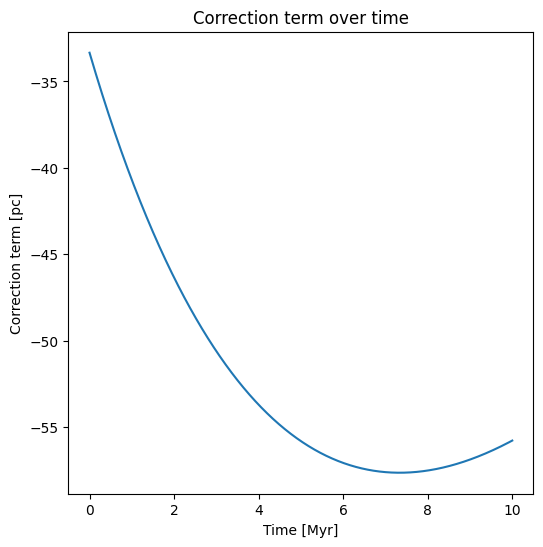

In [173]:
plt.figure(figsize=(6, 6))
times = np.linspace(0, 10, 1001)
plt.plot(times, correction_distance[0]/8)
plt.xlabel('Time [Myr]')
plt.ylabel('Correction term [pc]')
plt.title('Correction term over time')
plt.show()


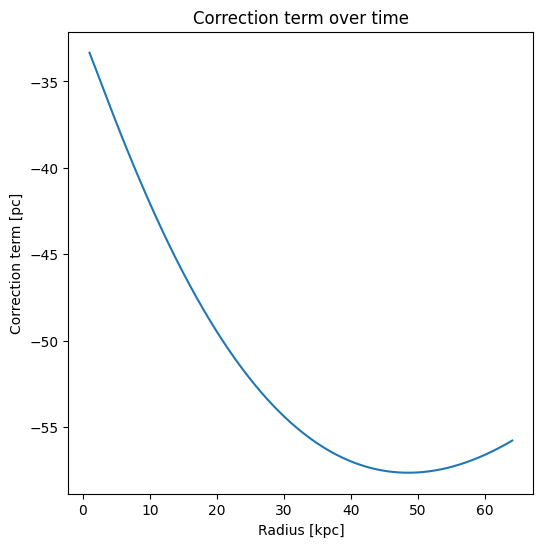

In [175]:
plt.figure(figsize=(6, 6))
times = np.linspace(0, 10, 1001)
plt.plot(R[0], correction_distance[0]/8)
plt.xlabel('Radius [kpc]')
plt.ylabel('Correction term [pc]')
plt.title('Correction term over time')
plt.show()


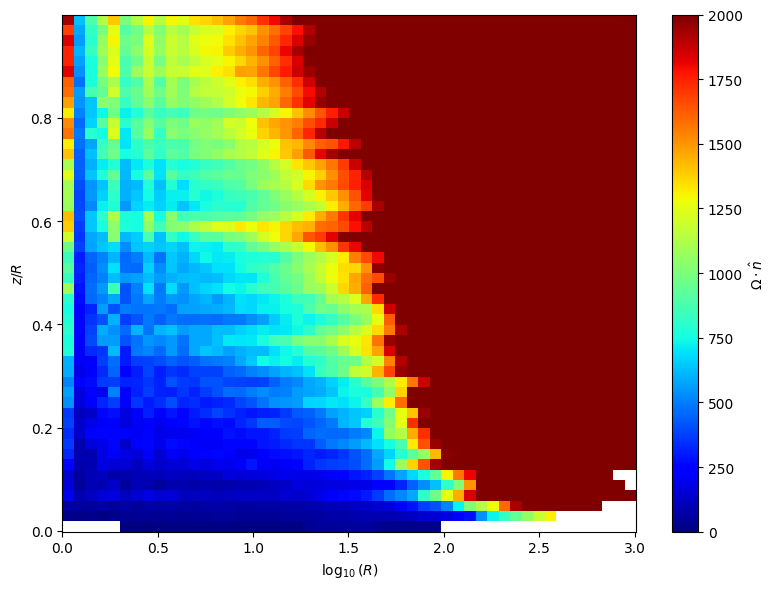

In [186]:

# Choose how many bins you want in each dimension
xbins = 50  # bins in z
ybins = 50  # bins in log10(VR)

zf = z.flatten()
VRf = VR.flatten()
Vzf = Vz.flatten()
Rf = R.flatten()
correction_distance_f = correction_distance.flatten()  

ratio = Vzf/Rf*VRf
# Use binned_statistic_2d to compute the mean ratio in each (z, logVR) bin
# statistic='mean' can also be 'median', 'count', 'sum', etc.
stat, xedges, yedges, binnum = binned_statistic_2d(
    y=zf/Rf,
    x=np.log10(Rf),
    values=np.abs(correction_distance_f),
    statistic='mean',
    bins=[xbins, ybins]
)

# 'stat' is a 2D array of the same shape as bins: (xbins, ybins)
# We can plot it with pcolormesh (or imshow).
plt.figure(figsize=(8, 6))
# Note that stat is indexed as stat[ix, iy], but pcolormesh expects
# xedges (length xbins+1) along the horizontal axis, yedges (length ybins+1)
# along the vertical axis, so we transpose 'stat' in pcolormesh.
plt.pcolormesh(xedges, yedges, stat.T, cmap='jet', shading='auto', vmin= 0, vmax= 2e3)

# Colorbar labeling
cb = plt.colorbar()
cb.set_label(r'$\Omega \cdot \hat{n}$ ')

plt.xlabel(r'$\log_{10}(R)$')
plt.ylabel(r'$z/R$')
#plt.title(r'')
plt.tight_layout()
#plt.xlim(-2, 2)
plt.show()

In [ ]:
def correction_sergey(Vz, Ro, mu, n):
    """
    Compute the correction term for the distance to the source
    """
    n_norm = n/np.linalg.norm(n)
    mu_v = np.random.rand(3)
    mu_v -= mu_v.dot(n_norm) * n_norm
    VxR = np.cross(Vz, Ro, axis=-1)
    correction_distance = np.dot(VxR, n_norm)
    return correction_distance  

In [195]:
import numpy as np
import astropy.units as u
import astropy.coordinates as coord
from numba import njit
from astropy.table import Table
import os
import astropy
import pandas as pd

def compute_R0_V0_SI():
    """
    Define the position and velocity of the Galactic Center in Galactocentric frame
    Here, we're using the position of the Sun in the Galactocentric frame,
    which by definition is at (x, y, z) = (0, 0, 0) in Galactocentric coordinates.
    We then transform this to the ICRS frame to get the position and velocity vectors.

    input:
        None
    output:
        R0: position vector pointing from the Galactic Center to the Sun in ICRS frame
        V0: velocity vector of the Sun in ICRS frame
    """
    galcen_coord = coord.Galactocentric(
        x=0 * u.kpc,
        y=0 * u.kpc,
        z=0 * u.kpc,
        v_x=0 * u.km / u.s,
        v_y=0 * u.km / u.s,
        v_z=0 * u.km / u.s
    )
    # Transform to ICRS frame
    icrs_coord = galcen_coord.transform_to(coord.ICRS())
    # Get the position and velocity in ICRS frame (in SI units)
    X0 = icrs_coord.cartesian.xyz.to(u.m).value  # position in meters
    V0 = icrs_coord.velocity.d_xyz.to(u.m / u.s).value  # velocity in m/s

    # Get the vector pointing from the Galactic Center to the Sun in ICRS frame
    R0 = -X0  # Shape (3,)
    V0 = -V0  # Shape (3,)
    return R0, V0

def compute_e_z_SI():
    """
    Get the unit vector for the Galactocentric Z in ICRS frame.

    input:
        None
    output:
        ez: unit vector pointing from the Galactic Center to the North Galactic Pole in ICRS frame
    """
    galcen_coord = coord.Galactocentric(
        x=0 * u.kpc,
        y=0 * u.kpc,
        z=1 * u.kpc,
        v_x=0 * u.km / u.s,
        v_y=0 * u.km / u.s,
        v_z=0 * u.km / u.s
    )
    # Transform to ICRS frame
    icrs_coord = galcen_coord.transform_to(coord.ICRS())
    # Get the position and velocity in ICRS frame (in SI units)
    X0 = icrs_coord.cartesian.xyz.to(u.m).value  # position in meters

    # Get the vector pointing from the Galactic Center to the Sun in ICRS frame
    ez = X0  # Shape (3,)

    # Normalize the vector
    ez /= np.linalg.norm(ez)

    return ez

In [196]:
ez = compute_e_z_SI()

In [201]:
ez

array([-0.16052347, -0.89109973, -0.42446847])

In [193]:
R0_SI, V0_SI = compute_R0_V0_SI()

In [250]:

def getdist_vectorized_original(ra_rad, dec_rad, pmra_rad_s, pmdec_rad_s,
                       epmra_rad_s, epmdec_rad_s, R0, V0):
    """
    Compute several derived quantities from Gaia-like observables, assuming a radial trajectory:
      - plx_i : implied parallax [1/m]
      - eplx_i: parallax error    [1/m]
      - VGCR_i: velocity in the Galactocentric reference frame [m/s]
      - VR_i  : radial velocity   [m/s]
      - D_i   : distance          [m]
      - eD_i  : distance error    [m]

    Parameters
    ----------
    ra_rad       : float or ndarray
        Right ascension in radians.
    dec_rad      : float or ndarray
        Declination in radians.
    pmra_rad_s   : float or ndarray
        Proper motion in RA (radians/sec).
    pmdec_rad_s  : float or ndarray
        Proper motion in Dec (radians/sec).
    epmra_rad_s  : float or ndarray
        Uncertainty in pmra_rad_s (radians/sec).
    epmdec_rad_s : float or ndarray
        Uncertainty in pmdec_rad_s (radians/sec).
    R0           : 3-element array
        Position of the Sun / observer in Galactocentric coords (m).
    V0           : 3-element array
        Velocity of the Sun / observer in Galactocentric coords (m/s).

    Returns
    -------
    plx_i  : ndarray
        Implied parallax (1/m).
    eplx_i : ndarray
        Error on the parallax (1/m).
    VGCR_i : ndarray
        Velocity in the Galactocentric reference frame (m/s).
    VR_i   : ndarray
        Radial velocity (m/s).
    D_i    : ndarray
        Distance (m).
    eD_i   : ndarray
        Distance uncertainty (m).

    Notes
    -----
    1) D_i is computed as 1 / plx_i, which is also equivalent to:
         D_i = - (dot_V0_R0n / dot_mu_R0n).
       We then propagate errors directly from pmra, pmdec to get eD_i.

    2) R0 and V0 are treated here as exact (no uncertainty). If you need
       to account for their errors, you must propagate them separately.

    3) This linear approximation is valid only if the fractional errors
       in pmra, pmdec remain small. If Gaia parallax is near zero or
       negative, or you have large fractional errors, you may need a
       more careful (Bayesian) approach.
    """
    # Convert single floats to arrays
    if isinstance(ra_rad, np.float64):
        ra_rad = np.array([ra_rad])
    N = len(ra_rad)
    
    plx = np.empty(N)
    eplx = np.empty(N)
    VGCR = np.empty(N)
    VR = np.empty(N)
    Darr = np.empty(N)
    eDarr = np.empty(N)

    R02 = np.sum(R0**2)
    V0R0 = np.dot(V0, R0)

    ra_r = ra_rad
    dec_r = dec_rad

    cos_ra = np.cos(ra_r)
    sin_ra = np.sin(ra_r)
    cos_dec = np.cos(dec_r)
    sin_dec = np.sin(dec_r)

    n0 = cos_ra * cos_dec
    n1 = sin_ra * cos_dec
    n2 = sin_dec

    # Cross product of R0 and n
    R0n0 = n1 * R0[2] - n2 * R0[1]
    R0n1 = -(n0 * R0[2] - n2 * R0[0])
    R0n2 = n0 * R0[1] - n1 * R0[0]

    # pmra basis vector
    e10 = -sin_ra
    e11 =  cos_ra
    e12 =  0.0

    # pmdec basis vector
    e20 = -cos_ra * sin_dec
    e21 = -sin_ra * sin_dec
    e22 =  cos_dec

    # Build velocity vector from pmra, pmdec
    mu0 = pmra_rad_s * e10 + pmdec_rad_s * e20
    mu1 = pmra_rad_s * e11 + pmdec_rad_s * e21
    mu2 = pmra_rad_s * e12 + pmdec_rad_s * e22

    # Dot products
    dot_V0_R0n = V0[0]*R0n0 + V0[1]*R0n1 + V0[2]*R0n2  # A
    dot_mu_R0n = mu0*R0n0 + mu1*R0n1 + mu2*R0n2       # B

    # Implied parallax
    plx_i = - dot_mu_R0n / dot_V0_R0n  # 1/m

    # Derivative components for eplx
    dot_e1_R0n = e10*R0n0 + e11*R0n1 + e12*R0n2
    dot_e2_R0n = e20*R0n0 + e21*R0n1 + e22*R0n2

    eplx_i = np.sqrt(
        (dot_e1_R0n * epmra_rad_s)**2 + 
        (dot_e2_R0n * epmdec_rad_s)**2
    ) / dot_V0_R0n  # 1/m

    # Distance in meters
    # Equivalent to 1.0 / plx_i, but let's be explicit
    D = - dot_V0_R0n / dot_mu_R0n

    # For error propagation, define:
    #   D = -(A / B), where A = dot_V0_R0n, B = dot_mu_R0n.
    #   B = alpha*pmra + beta*pmdec, with:
    alpha = dot_e1_R0n  # partial B wrt pmra
    beta  = dot_e2_R0n  # partial B wrt pmdec

    # partial D / partial pmra = A * alpha / B^2
    # partial D / partial pmdec = A * beta / B^2
    # => (sigma_D)^2 = (A^2 / B^4)[alpha^2 (sigma_pmra)^2 + beta^2 (sigma_pmdec)^2]
    A = dot_V0_R0n
    B = dot_mu_R0n
    sig_pmra  = epmra_rad_s
    sig_pmdec = epmdec_rad_s

    eD = np.abs(A / (B**2)) * np.sqrt(alpha**2 * sig_pmra**2 + 
                                      beta**2  * sig_pmdec**2)

    # Next, compute VR_i and VGCR_i as in your original code
    nV0  = V0[0]*n0 + V0[1]*n1 + V0[2]*n2
    nR0  = R0[0]*n0 + R0[1]*n1 + R0[2]*n2
    mun  = mu0*n0 + mu1*n1 + mu2*n2
    muR0 = mu0*R0[0] + mu1*R0[1] + mu2*R0[2]

    denom = R02 - nR0**2
    VR_i = -1.0 / denom * (
        (nV0 * R02 - V0R0 * nR0)
        + D * (nV0 * nR0 - V0R0 + mun*R02 - muR0*nR0)
        + D**2 * (mun * nR0 - muR0)
    )  # [m/s]

    # Compute VGCR
    numerator = V0R0 + D*muR0 + VR_i*nR0 + D*nV0 + D**2*mun + D*VR_i
    R = np.sqrt(R02 + D**2 + 2.0 * D * nR0)
    VGCR_i = numerator / R  # [m/s]

    # Store results
    plx[:]   = plx_i
    eplx[:]  = eplx_i
    VGCR[:]  = VGCR_i
    VR[:]    = VR_i
    Darr[:]  = D
    eDarr[:] = eD

    return plx, eplx, VGCR, VR, Darr, eDarr

In [212]:
# test code:

ra_rad = np.radians(45.0)
dec_rad = np.radians(30.0)
pmra_rad_s = np.radians(2.0)
pmdec_rad_s = np.radians(1.0)
epmra_rad_s = np.radians(0.1)
epmdec_rad_s = np.radians(0.1)
vz_test = np.mean(Vz.ravel())
ez = compute_e_z_SI()

getdist_vectorized2(ra_rad, dec_rad, pmra_rad_s, pmdec_rad_s,
                       epmra_rad_s, epmdec_rad_s, R0_SI, V0_SI, Vz, ez)

[0.61237244] [0.61237244] 0.49999999999999994


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [228]:
import numpy as np

def cross_2D(a, b):
    """
    Vectorized cross product for two arrays of shape (N,3),
    returning shape (N,3).
    """
    return np.column_stack((
        a[:,1]*b[:,2] - a[:,2]*b[:,1],
        a[:,2]*b[:,0] - a[:,0]*b[:,2],
        a[:,0]*b[:,1] - a[:,1]*b[:,0]
    ))

def dot_2D(a, b):
    """
    Vectorized dot product for two arrays of shape (N,3),
    returning shape (N,).
    """
    return a[:,0]*b[:,0] + a[:,1]*b[:,1] + a[:,2]*b[:,2]


def getdist_vectorized2(ra_rad, dec_rad, pmra_rad_s, pmdec_rad_s,
                        epmra_rad_s, epmdec_rad_s, R0, V0, Vz, ez):
    """
    Compute several derived quantities from Gaia-like observables, 
    allowing an extra velocity Vz along the direction ez, all in 
    a fully vectorized manner without np.cross or np.dot.

      - plx_i : implied parallax [1/m]
      - eplx_i: parallax error    [1/m]
      - VGCR_i: velocity in the Galactocentric reference frame [m/s]
      - VR_i  : radial velocity   [m/s]
      - D_i   : distance          [m]
      - eD_i  : distance error    [m]

    Parameters
    ----------
    ra_rad       : float or ndarray, shape (N,)
        Right ascension in radians.
    dec_rad      : float or ndarray, shape (N,)
        Declination in radians.
    pmra_rad_s   : float or ndarray, shape (N,)
        Proper motion in RA (radians/sec).
    pmdec_rad_s  : float or ndarray, shape (N,)
        Proper motion in Dec (radians/sec).
    epmra_rad_s  : float or ndarray, shape (N,)
        Uncertainty in pmra_rad_s (radians/sec).
    epmdec_rad_s : float or ndarray, shape (N,)
        Uncertainty in pmdec_rad_s (radians/sec).
    R0           : 3-element array, shape (3,)
        Position of the Sun / observer in chosen coords (m).
    V0           : 3-element array, shape (3,)
        Velocity of the Sun / observer in chosen coords (m/s).
    Vz           : float
        Velocity magnitude along the ez direction [m/s].
    ez           : 3-element array, shape (3,)
        Unit vector for the direction in which Vz is applied.

    Returns
    -------
    plx_i  : ndarray, shape (N,)
        Implied parallax (1/m).
    eplx_i : ndarray, shape (N,)
        Error on the parallax (1/m).
    VGCR_i : ndarray, shape (N,)
        Velocity in the Galactocentric reference frame (m/s).
    VR_i   : ndarray, shape (N,)
        Radial velocity (m/s).
    D_i    : ndarray, shape (N,)
        Distance (m).
    eD_i   : ndarray, shape (N,)
        Distance uncertainty (m).

    Notes
    -----
    1) D_i is computed as:
         D_i = -( dot(V0, R0 x n) / dot(mu, R0 x n ) ) + correction_from_Vz
       Then plx_i = 1.0 / D_i.

    2) R0, V0, ez are treated as exact (no uncertainty).
       If you need to account for their errors, you'll need to propagate
       them separately.

    3) This linear approximation is valid only if fractional errors in pmra,
       pmdec remain small. If Gaia parallax is near zero or negative, or if
       large fractional errors occur, consider a more careful (Bayesian) approach.
    """

    # Convert all scalar-like inputs to 1D arrays
    ra_rad       = np.atleast_1d(ra_rad)
    dec_rad      = np.atleast_1d(dec_rad)
    pmra_rad_s   = np.atleast_1d(pmra_rad_s)
    pmdec_rad_s  = np.atleast_1d(pmdec_rad_s)
    epmra_rad_s  = np.atleast_1d(epmra_rad_s)
    epmdec_rad_s = np.atleast_1d(epmdec_rad_s)

    N = len(ra_rad)  # number of objects

    # Prepare output arrays
    plx   = np.empty(N)
    eplx  = np.empty(N)
    VGCR  = np.empty(N)
    VR    = np.empty(N)
    Darr  = np.empty(N)
    eDarr = np.empty(N)

    # Broadcast R0, V0, ez to shape (N,3)
    # so we can do vectorized cross/dot operations
    R0_2D = np.tile(R0, (N,1))  # shape (N,3)
    V0_2D = np.tile(V0, (N,1))  # shape (N,3)
    ez_2D = np.tile(ez, (N,1))  # shape (N,3)

    # Some precomputed scalars
    # We'll need R0^2 = sum(R0^2) for each star, but that's the same number repeated
    R02 = np.sum(R0**2)  # scalar
    V0R0 = np.sum(V0*R0) # dot(V0, R0), scalar

    # Build the line-of-sight unit vector n shape (N,3)
    cos_ra  = np.cos(ra_rad)
    sin_ra  = np.sin(ra_rad)
    cos_dec = np.cos(dec_rad)
    sin_dec = np.sin(dec_rad)

    n0 = cos_ra * cos_dec  # shape (N,)
    n1 = sin_ra * cos_dec  # shape (N,)
    n2 = sin_dec           # shape (N,)

    n_vec = np.column_stack((n0, n1, n2))  # shape (N,3)

    # Build pm vectors mu shape (N,3)
    # pmra basis
    e10 = -sin_ra
    e11 =  cos_ra
    e12 = np.zeros_like(ra_rad)

    # pmdec basis
    e20 = -cos_ra*sin_dec
    e21 = -sin_ra*sin_dec
    e22 =  cos_dec

    mu0 = pmra_rad_s*e10 + pmdec_rad_s*e20  # shape (N,)
    mu1 = pmra_rad_s*e11 + pmdec_rad_s*e21  # shape (N,)
    mu2 = pmra_rad_s*e12 + pmdec_rad_s*e22  # shape (N,)

    mu_vec = np.column_stack((mu0, mu1, mu2))  # shape (N,3)

    # Cross products
    # R0 x n
    R0n = cross_2D(R0_2D, n_vec)    # shape (N,3)
    # R0 x ez
    R0xe = cross_2D(R0_2D, ez_2D)   # shape (N,3)

    # Dot products
    # dot(V0, R0 x n) = shape (N,)
    dot_V0_R0n  = dot_2D(V0_2D, R0n)
    # dot(mu, R0 x n) = shape (N,)
    dot_mu_R0n  = dot_2D(mu_vec, R0n)
    # dot(n, R0 x ez) = shape (N,)
    dot_n_R0xeZ = dot_2D(n_vec, R0xe)

    # Original radial distance: D_orig = - (dot(V0, R0 x n) / dot(mu, R0 x n))
    # Then add the extra velocity term from Vz:
    # new_term = - Vz * dot(n, R0 x ez) / dot(mu, R0 x n)
    # Final: D = D_orig + new_term
    A = dot_V0_R0n
    B = dot_mu_R0n
    D_orig = -A / B
    new_term = - Vz * dot_n_R0xeZ / B
    D = D_orig + new_term

    # parallax = 1 / D
    plx_i = 1.0 / D

    # partial derivatives for parallax error
    # dot(e1, R0n) and dot(e2, R0n)
    # e1 = (e10, e11, e12) for pmra
    # e2 = (e20, e21, e22) for pmdec
    e1_vec = np.column_stack((e10, e11, e12))
    e2_vec = np.column_stack((e20, e21, e22))

    dot_e1_R0n = dot_2D(e1_vec, R0n)  # shape (N,)
    dot_e2_R0n = dot_2D(e2_vec, R0n)  # shape (N,)

    # eplx_i = sqrt((dot_e1_R0n * epmra_rad_s)^2 + (dot_e2_R0n * epmdec_rad_s)^2 ) / abs(dot_V0_R0n)
    # staying consistent with your original formula
    eplx_i = np.sqrt(
        (dot_e1_R0n * epmra_rad_s)**2 +
        (dot_e2_R0n * epmdec_rad_s)**2
    ) / np.abs(dot_V0_R0n)

    # distance error ignoring partial wrt Vz
    # from D = -(A / B) => eD ~ (|A| / B^2)* sqrt(...) as in your code
    A_abs = np.abs(A)
    B_sq = B**2

    alpha = dot_e1_R0n
    beta  = dot_e2_R0n

    sig_pmra  = epmra_rad_s
    sig_pmdec = epmdec_rad_s

    eD = A_abs / B_sq * np.sqrt(alpha**2*sig_pmra**2 + beta**2*sig_pmdec**2)

    # Next compute VR_i, VGCR_i similarly to your original code:
    nV0 = dot_2D(n_vec, V0_2D)
    nR0 = n0*R0[0] + n1*R0[1] + n2*R0[2]  # shape (N,) via broadcast
    mun = dot_2D(mu_vec, n_vec)
    muR0 = (mu0*R0[0] + mu1*R0[1] + mu2*R0[2])

    denom = R02 - nR0**2
    # VR_i
    # Carefully define a "numerator" for VR:
    # (nV0 * R02 - V0R0 * nR0)
    # + D*(nV0*nR0 - V0R0 + mun*R02 - muR0*nR0)
    # + D^2*(mun*nR0 - muR0)
    term1 = nV0*R02 - V0R0*nR0
    term2 = D*(nV0*nR0 - V0R0 + mun*R02 - muR0*nR0)
    term3 = D**2*(mun*nR0 - muR0)
    VR_top = term1 + term2 + term3
    VR_i = -VR_top / denom

    # VGCR
    # numerator = V0R0 + D*muR0 + VR_i*nR0 + D*nV0 + D^2*mun + D*VR_i
    numerator = (
        V0R0
        + D*muR0
        + VR_i*nR0
        + D*nV0
        + D**2*mun
        + D*VR_i
    )
    R_val = np.sqrt(R02 + D**2 + 2.0*D*nR0)
    VGCR_i = numerator / R_val

    # Store results
    plx[:]   = plx_i
    eplx[:]  = eplx_i
    VGCR[:]  = VGCR_i
    VR[:]    = VR_i
    Darr[:]  = D
    eDarr[:] = eD

    return plx, eplx, VGCR, VR, Darr, eDarr, new_term, D_orig


In [252]:
import numpy as np

# Example usage of your getdist_vectorized2 function with purely array inputs

# Suppose we have 2 stars (N=2):
ra_rad       = np.array([0.2, np.pi/4])        # RA in radians
dec_rad      = np.array([0.1, -np.pi/8])       # Dec in radians

pmra_rad_s   = np.array([1e-13, 1.5e-5])  # Proper motion in RA (rad/s)
pmdec_rad_s  = np.array([1e-13, 1.2e-5])  # Proper motion in Dec (rad/s)
epmra_rad_s  = np.array([1e-15, 1e-15])    # Uncertainty in pmra_rad_s
epmdec_rad_s = np.array([1e-15, 1e-15])    # Uncertainty in pmdec_rad_s

# Example Sun/observer position and velocity (must be consistent with your units).
# Here, we just pick "some" values for demonstration:
R0 = np.array([8.0e3, 0.0, 0.0])    # Position of the Sun in meters (?) 
V0 = np.array([220.0, 0.0, 0.0])    # Velocity of the Sun in 9m/s (?) 
                                    # (You would replace these with your actual R0, V0.)

vz_test = np.array([np.mean(Vz.ravel()), np.mean(Vz.ravel())])
ez = compute_e_z_SI()
# Now call your function. Make sure you've defined getdist_vectorized2 
# somewhere above or have imported it.
plx, eplx, VGCR, VR, Darr, eDarr, correction, D_original = getdist_vectorized2(
    ra_rad, dec_rad, 
    pmra_rad_s, pmdec_rad_s,
    epmra_rad_s, epmdec_rad_s, 
    R0, V0, 
    vz_test, ez
)

print("Implied Parallax (1/m) =", plx)
print("Parallax Error (1/m)   =", eplx)
print("Velocity (Galactocentric ref) [m/s] =", VGCR)
print("Radial Velocity [m/s]            =", VR)
print("Distance [pc]                     =", Darr*u.m.to(u.pc))
print("Distance Error [pc]               =", eDarr*u.m.to(u.pc))
print("Correction term [m]              =", correction)
print("Original distance [m]            =", D_original)

# getdist_vectorized2(ra_rad, dec_rad, pmra_rad_s, pmdec_rad_s,
#                        epmra_rad_s, epmdec_rad_s, R0_SI, V0_SI, Vz, ez)

Implied Parallax (1/m) = [-1.13850209e-12  1.15780160e-05]
Parallax Error (1/m)   = [inf inf]
Velocity (Galactocentric ref) [m/s] = [2.42128505e+10 2.51169010e+03]
Radial Velocity [m/s]            = [-2.42128507e+10  2.36249477e+03]
Distance [pc]                     = [-2.84652908e-05  2.79907998e-12]
Distance Error [pc]               = [0. 0.]
Correction term [m]              = [-8.78347095e+11  8.63705834e+04]
Original distance [m]            = [-0. -0.]


/tmp/ipykernel_3273/2856545970.py:186: RuntimeWarning: divide by zero encountered in divide
  eplx_i = np.sqrt(


In [249]:
def post_process_results(plx, eplx, VGCR, VR, D, eD):
    """
    Post-process the results from the optimized function

    input:
        plx: parallax in 1/m
        eplx: parallax error in 1/m
        VGCR: VGCR in m/s
        VR: VR in m/s

    output:
        plx_mas: parallax in mas
        eplx_mas: parallax error in mas
        VGCR_kms: VGCR in km/s
        VR_kms: VR in km/s
    """
    # Remove units from plx, eplx, VGCR, and VR
    if isinstance(plx, u.Quantity):
        plx = plx.value
    if isinstance(eplx, u.Quantity):
        eplx = eplx.value

    # check if plx and eplx are 'Series' objects
    if isinstance(plx, pd.Series):
        plx = plx.values
    if isinstance(eplx, pd.Series):
        eplx = eplx.values


    # If this stops working try adding .value after plx and eplx
    try:
        plx_mas = (plx/u.meter).to(1/u.pc, equivalencies=u.parallax())*1e3
        eplx_mas = (eplx/u.meter).to(1/u.pc, equivalencies=u.parallax())*1e3
    
    except:
        print('Unit conversion error in plx and eplx')
        plx_mas = (plx.value / u.meter).to(1/u.pc, equivalencies=u.parallax())*1e3
        eplx_mas = (eplx.value / u.meter).to(1/u.pc, equivalencies=u.parallax())*1e3
    

    # VGCR and VR are in m/s, convert to km/s
    VGCR_kms = VGCR / 1e3
    VR_kms = VR / 1e3

    # D is in meters, convert to pc
    D_pc = D*u.m.to(u.pc)
    eD_pc = eD*u.m.to(u.pc)


    return plx_mas, eplx_mas, VGCR_kms, VR_kms, D_pc, eD_pc

def implied_calculations(data, vz, ez):
    # Convert positions to radians
    ra_rad = np.deg2rad(data['ra'])
    dec_rad = np.deg2rad(data['dec'])

    # Convert proper motions to radians per second
    masyr_to_radsec = (1 * u.mas / u.yr).to(u.rad / u.s).value
    pmra_rad_s = data['pmra'] * masyr_to_radsec
    pmdec_rad_s = data['pmdec'] * masyr_to_radsec
    epmra_rad_s = data['pmra_error'] * masyr_to_radsec
    epmdec_rad_s = data['pmdec_error'] * masyr_to_radsec

    # Compute R0 and V0 in SI units (meters and meters per second)
    #print('Computing R0 and V0...')
    R0_SI, V0_SI = compute_R0_V0_SI()

    # Compute ez in SI units
    ez = compute_e_z_SI()

    # Run optimized function
    #print('Computing distances and velocities...')
    # plx_opt, eplx_opt, VGCR_opt, VR_opt = getdist_vectorized(
    #     ra_rad, dec_rad, pmra_rad_s, pmdec_rad_s, epmra_rad_s, epmdec_rad_s, R0_SI, V0_SI
    # )

    plx_opt, eplx_opt, VGCR_opt, VR_opt, D_i, D_i_error, correction, D_original = getdist_vectorized2(
    ra_rad, dec_rad, pmra_rad_s, pmdec_rad_s, epmra_rad_s, epmdec_rad_s, R0_SI, V0_SI, vz, ez
    )
    #print('Distances and velocities computed successfully!')
    # Post-process the results
    plx_mas, eplx_mas, VGCR_kms, VR_kms, D_pc, eD_pc = post_process_results(plx_opt, eplx_opt, 
                                                                            VGCR_opt, VR_opt, 
                                                                            D_i, D_i_error)

    # Save the results to a new table
    data['implied_parallax'] = plx_mas #mas
    data['implied_parallax_error'] = eplx_mas #mas
    data['VGCR'] = VGCR_kms
    data['VR'] = VR_kms
    data['implied_distance'] = D_pc
    data['implied_distance_error'] = eD_pc
    data['D_correction'] = correction
    data['D_original'] = D_original

    return data

In [263]:
# test with a pixel
pixel_data = Table.read('/app/data/Data/Gaia_tests/gaia_by_healpix/healpix_2161.fits')



In [257]:

def getdist_vectorized(ra_rad, dec_rad, pmra_rad_s, pmdec_rad_s,
                  epmra_rad_s, epmdec_rad_s, R0, V0):
    # check if ra_rad is a numpy.float64
    if isinstance(ra_rad, np.float64):
        ra_rad = np.array([ra_rad])
    N = len(ra_rad)
    plx = np.empty(N)
    eplx = np.empty(N)
    VGCR = np.empty(N)
    VR = np.empty(N)

    R02 = np.sum(R0**2)
    V0R0 = np.dot(V0, R0)


    ra_r = ra_rad
    dec_r = dec_rad

    cos_ra = np.cos(ra_r)
    sin_ra = np.sin(ra_r)
    cos_dec = np.cos(dec_r)
    sin_dec = np.sin(dec_r)

    n0 = cos_ra * cos_dec
    n1 = sin_ra * cos_dec
    n2 = sin_dec

    # Cross product of R0 and n
    R0n0 = n1 * R0[2] - n2 * R0[1]
    R0n1 = - (n0 * R0[2] - n2 * R0[0])
    R0n2 = n0 * R0[1] - n1 * R0[0]

    # pmra basis vector
    e10 = -sin_ra
    e11 = cos_ra
    e12 = 0.0

    # pmdec basis vector
    e20 = -cos_ra * sin_dec
    e21 = -sin_ra * sin_dec
    e22 = cos_dec

    # proper motions in rad/s (already converted)
    mu0 = pmra_rad_s * e10 + pmdec_rad_s * e20
    mu1 = pmra_rad_s * e11 + pmdec_rad_s * e21
    mu2 = pmra_rad_s * e12 + pmdec_rad_s * e22

    # DOT products
    dot_V0_R0n = V0[0] * R0n0 + V0[1] * R0n1 + V0[2] * R0n2
    dot_mu_R0n = mu0 * R0n0 + mu1 * R0n1 + mu2 * R0n2

    plx_i = - dot_mu_R0n / dot_V0_R0n  # Units: 1/m

    # Compute eplx
    dot_e1_R0n = e10 * R0n0 + e11 * R0n1 + e12 * R0n2
    dot_e2_R0n = e20 * R0n0 + e21 * R0n1 + e22 * R0n2

    eplx_i = np.sqrt(
        (dot_e1_R0n * epmra_rad_s)**2 + (dot_e2_R0n * epmdec_rad_s)**2
    ) / dot_V0_R0n  # Units: 1/m

    # Compute other DOT products
    nV0 = V0[0] * n0 + V0[1] * n1 + V0[2] * n2
    nR0 = R0[0] * n0 + R0[1] * n1 + R0[2] * n2
    mun = mu0 * n0 + mu1 * n1 + mu2 * n2
    muR0 = mu0 * R0[0] + mu1 * R0[1] + mu2 * R0[2]

    D = 1.0 / plx_i  # Units: m

    denom = R02 - nR0**2
    VR_i = -1 / denom * (
        (nV0 * R02 - V0R0 * nR0) + D *
        (nV0 * nR0 - V0R0 + mun * R02 - muR0 * nR0) + D**2 *
        (mun * nR0 - muR0)
    )  # Units: m/s

    # Compute VGCR
    numerator = V0R0 + D * muR0 + VR_i * nR0 + D * nV0 + D**2 * mun + D * VR_i
    R = np.sqrt(R02 + D**2 + 2 * D * nR0)
    VGCR_i = numerator / R  # Units: m/s

    return plx_i, eplx_i, VGCR_i, VR_i


In [266]:
data = pixel_data.to_pandas()
ra_rad = np.deg2rad(data['ra'])
dec_rad = np.deg2rad(data['dec'])

# Convert proper motions to radians per second
masyr_to_radsec = (1 * u.mas / u.yr).to(u.rad / u.s).value
pmra_rad_s = data['pmra'] * masyr_to_radsec
pmdec_rad_s = data['pmdec'] * masyr_to_radsec
epmra_rad_s = data['pmra_error'] * masyr_to_radsec
epmdec_rad_s = data['pmdec_error'] * masyr_to_radsec

# use the mean Vz
vz_test = np.array(0)# np.array([np.mean(Vz.ravel())])

plx, eplx, VGCR, VR, Darr, eDarr, correction, D_original = getdist_vectorized2(
    ra_rad, dec_rad, 
    pmra_rad_s, pmdec_rad_s,
    epmra_rad_s, epmdec_rad_s, 
    R0, V0, 
    vz_test, ez
)

# check that it gives the same result as the original function for vz = 0
plx_i, eplx_i, VGCR_i, VR_i = getdist_vectorized(
                                            ra_rad, dec_rad, 
                                            pmra_rad_s, pmdec_rad_s,
                                            epmra_rad_s, epmdec_rad_s, 
                                            R0, V0
)



/tmp/ipykernel_3273/2856545970.py:172: RuntimeWarning: divide by zero encountered in divide
  plx_i = 1.0 / D
/tmp/ipykernel_3273/2856545970.py:186: RuntimeWarning: divide by zero encountered in divide
  eplx_i = np.sqrt(


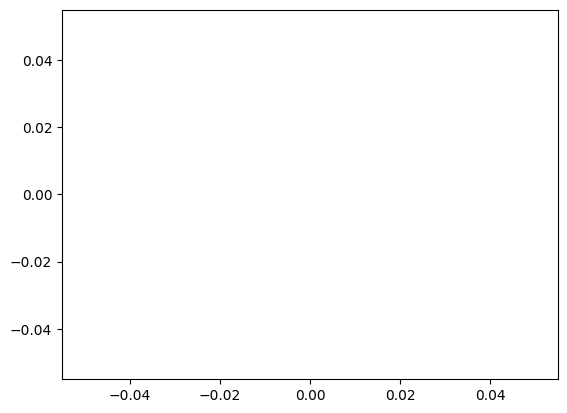

In [268]:
plx_diff = plx-plx_i
eplx_diff = eplx-eplx_i
VGCR_diff = VGCR-VGCR_i
VR_diff = VR-VR_i

plt.figure()
plt.scatter(plx, plx_diff)
plt.show()

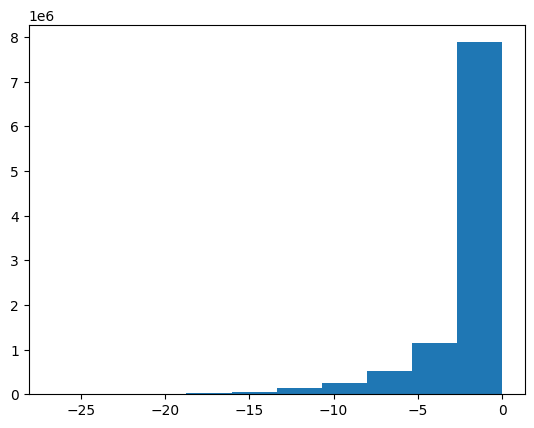

In [205]:
plt.figure()
plt.hist(Vz.ravel())
plt.show()

In [206]:
np.mean(Vz.ravel())

np.float64(-1.7522933758010233)